In [75]:
from datetime import datetime

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import plotly.graph_objects as go
from plotly.subplots import make_subplots

np.set_printoptions(suppress=True, precision=5) # Disable scientific notation

SELECTED_RUNS = [
    2, 4, 5, 
    6, 
    7, 8, 9
]

# pacejka_p0 = [0.2, 2.1, 67, 0, 0.3]
b0 = 0.2
c0 = 2.7
e0 = 0.5
f0 = 0.3

In [128]:
def get_run_data(selected_runs):
    metric_data = pd.DataFrame()

    for rn in selected_runs:
        # Import the data
        metric_datum = pd.read_csv(f'./SN5_R9_Lateral/run{rn}.csv')

        metric_datum["ET"] = metric_datum["ET"] - metric_datum["ET"].iloc[0]
        
        if len(metric_data) != 0:
            metric_datum["ET"] = metric_datum["ET"] + metric_data["ET"].iloc[-1]

        metric_data = pd.concat([metric_data, metric_datum])
        print(f"Loaded file run{rn}.dat ({len(metric_datum)} rows)")

    return metric_data

def bin_by_param(df, bins, param_col):
    out = []
    for lb, ub in bins:
        sub = df[(df[param_col] >= lb) & (df[param_col] < ub)]
        out.append(sub)
    return out

In [77]:
def pacejka_lateral(alpha, B, C, D, E, F):
    return D * np.sin(C * np.arctan(B * alpha - E * (B * alpha - np.arctan(B * alpha))) + F)

def fit_pacejka(df, x_col, y_col):
    popt, _ = curve_fit(
        pacejka_lateral, 
        df[x_col], 
        df[y_col], 
        p0=[b0, c0, max(abs(df[y_col])), e0, f0], 
        maxfev=50000
    )

    return popt

In [93]:
def camber_moments_fig(data_binned_IA):
    fig = make_subplots(rows=1, cols=3, subplot_titles=[f"IA={ia}" for ia in [0, 2, 4]])

    for i in range(3):
        data_bin_IA = data_binned_IA[i]

        Fz_bins = [[-1200, -1000], [-1000, -800], [-800, -500], [-500, -350], [-350, -100]]
        data_bin_AI_binned_FZ = bin_by_param(data_bin_IA, Fz_bins, "FZ")

        for j in range(5):
            Fz_value = int((Fz_bins[j][0] + Fz_bins[j][1]) / 2)

            bin_bin = data_bin_AI_binned_FZ[j]
            bin_bin = bin_bin[(bin_bin["SA"] > -10) & (bin_bin["SA"] < 10)]

            pacejka_params = fit_pacejka(bin_bin, "SA", "MZ")
            print(f"Fitted Pacejka for Fz={Fz_value} and IA={i * 2}")
            
            Fz_sample = bin_bin.sample(n = 1000)

            fig.add_trace(
                go.Scatter(
                    x=Fz_sample["SA"],
                    y=Fz_sample["MZ"],
                    mode="markers", 
                    name=f"F_z = {Fz_value}", 
                    marker=dict(color=["red", "orange", "yellow", "green", "blue"][j], opacity=0.2),
                    legendgroup=f"group{Fz_value}",
                    showlegend=(i==0)
                ), 
                row=1,
                col=i+1
            )

            xspace = np.linspace(min(Fz_sample["SA"]), max(Fz_sample["SA"]), 1000)

            fig.add_trace(
                go.Scatter(
                    x=xspace,
                    y=pacejka_lateral(xspace, *pacejka_params), 
                    name=f"Fitted Pacejka Curve",
                    marker=dict(color=["red", "orange", "yellow", "green", "blue"][j])
                ), 
                row=1,
                col=i+1
            )

    fig.update_xaxes(title_text="Slip Angle (deg)")
    fig.update_yaxes(title_text="Self Aligning Torque (Nm)")
    fig.update_layout(title_text=f"Tire Moment at Tested IAs")

    return fig

In [129]:
all_data = get_run_data(SELECTED_RUNS)

Loaded file run2.dat (58755 rows)
Loaded file run4.dat (36194 rows)
Loaded file run5.dat (31138 rows)
Loaded file run6.dat (52331 rows)
Loaded file run7.dat (58762 rows)
Loaded file run8.dat (61020 rows)
Loaded file run9.dat (52322 rows)


In [124]:
round_six = get_run_data([6])

Loaded file run6.dat (52331 rows)


In [126]:
round_eight = get_run_data([8])

Loaded file run8.dat (61020 rows)


In [98]:
ia_bins = [[-0.1, 0.1], [1.9, 2.1], [3.9, 4.1]]
data_camber_bins = bin_by_param(all_data, ia_bins, "IA")

In [95]:
camber_four = data_camber_bins[2]
camber_four_load_650 = camber_two[(camber_two["FZ"] >= -800) & (camber_two["FZ"] < -500)]
sample = camber_two_load_1100.sample(1000)

# print("\n".join(list(str(pair) for pair in zip(sample["SA"],sample["MZ"]))))
# print(max(camber_four_load_650["MZ"]))

In [94]:
timestamp = datetime.now().strftime("%m%d_%H%M%S")
fig = camber_moments_fig(data_camber_bins)

fig.write_html(f"fy_out/figures/mz_sa_ia_bins_({timestamp}).html")

Fitted Pacejka for Fz=-1100 and IA=0
Fitted Pacejka for Fz=-900 and IA=0
Fitted Pacejka for Fz=-650 and IA=0
Fitted Pacejka for Fz=-425 and IA=0
Fitted Pacejka for Fz=-225 and IA=0
Fitted Pacejka for Fz=-1100 and IA=2
Fitted Pacejka for Fz=-900 and IA=2
Fitted Pacejka for Fz=-650 and IA=2


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 50000.

In [130]:
timestamp = datetime.now().strftime("%m%d_%H%M%S")

sample = data_camber_bins[0]
sample = sample[(sample["SA"] > -10) & (sample["SA"] < 10)]
sample = sample[sample["ET"] > 200]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=sample["SA"], 
    y=sample["MZ"],
    mode="markers",
    marker=dict(
        color=sample["ET"], 
        colorscale="Viridis", 
        showscale=True, 
        colorbar=dict(
            title="Time (s)"
        )
    ),
))

fig.write_html(f"fy_out/figures/mz_sa_fz_({timestamp}).html")

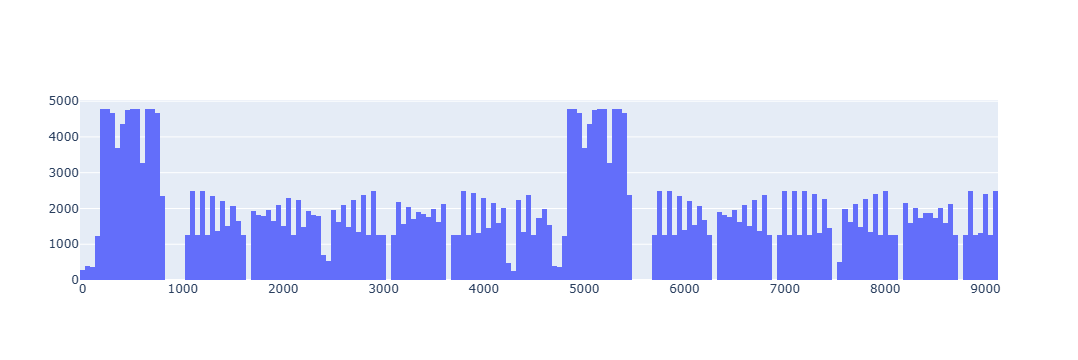

In [120]:
sample = all_data

fig = go.Figure()
fig.add_trace(go.Histogram(x=sample["ET"]))
fig.show()

In [131]:
timestamp = datetime.now().strftime("%m%d_%H%M%S")

sample = all_data
# sample = sample[(sample["SA"] > -10) & (sample["SA"] < 10)]
# sample = sample[sample["ET"] > 200]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=sample["ET"], 
    y=sample["SA"],
    # mode="markers",
    # marker=dict(
    #     color=sample["ET"], 
    #     colorscale="Viridis", 
    #     showscale=True, 
    #     colorbar=dict(
    #         title="Time (s)"
    #     )
    # ),
))

fig.write_html(f"fy_out/figures/sa_time_({timestamp}).html")

In [ ]:
fz_bins = [[-1200, -1000], [-1000, -800], [-800, -500], [-500, -350], [-350, -100]]

for data_camber_bin in data_camber_bins:
    

In [1]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminder_unfiltered.csv')

app = Dash()

# Requires Dash 2.17.0 or later
app.layout = [
    html.H1(children='Title of Dash App', style={'textAlign':'center'}),
    dcc.Dropdown(df.country.unique(), 'Canada', id='dropdown-selection'),
    dcc.Graph(id='graph-content')
]

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value')
)
def update_graph(value):
    dff = df[df.country==value]
    return px.line(dff, x='year', y='pop')

app.run(jupyter_mode="tab")

Dash app running on http://127.0.0.1:8050/


<IPython.core.display.Javascript object>